<a href="https://colab.research.google.com/github/pmap1986/Paula_Alfonso_KC/blob/main/Taller_10_Paula_Alfonso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de tiempo

Una serie de tiempo se define típicamente como una secuencia ordenada de valores que suelen estar igualmente espaciados en el tiempo.

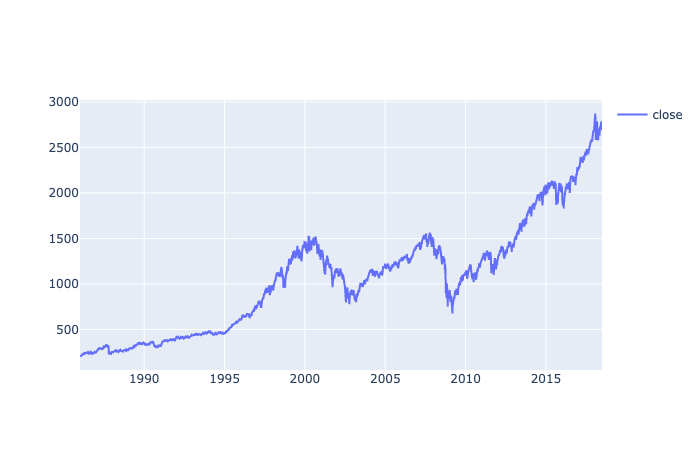

$$y_1,...,y_T,...,  y_t \in \mathbb{R}$$

Para predecir necesitamos una funcion $\mathit{f_T}$:
$y_{T+d} \approx \mathit{f_T}(y_T,...,y_1,d) \equiv \hat{y}_{T+d|T}$, donde $d \mathbb{1,...,D}$ D es el horizonte de prediccion.

**Patrones en las series de tiempo**:

- Trend and seasonality.
- Noise.
- Autocorrelated time series.
- Trend + Seasonality + Autocorrelation + Noise
- Non-Stationary Time Series

**Metodos clasicos para hacer predicciones de series de tiempo**:

- Autoregression (AR)
- Moving Average (MA)
- Autoregressive Moving Average (ARMA)
- Autoregressive Integrated Moving Average (ARIMA)
- Seasonal Autoregressive Integrated Moving-Average (SARIMA)
- Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
- Vector Autoregression (VAR)
- Vector Autoregression Moving-Average (VARMA)
- Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
- Simple Exponential Smoothing (SES)
- Holt Winter’s Exponential Smoothing (HWES)

## Trend and seasonality

In [2]:
import numpy as np                               # vectores y matrices
import pandas as pd                              # tablas y data manipulations
import matplotlib.pyplot as plt                  # plots
from matplotlib.pylab import rcParams
import seaborn as sns                            # mas plots
sns.set()

from dateutil.relativedelta import relativedelta # trabajar con fechas
from scipy.optimize import minimize              # 

import statsmodels.formula.api as smf            # statistics y econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # algunas funciones utiles
from tqdm import tqdm_notebook

import warnings                                  # quitar warnings 
warnings.filterwarnings('ignore')

%matplotlib inline

rcParams['figure.figsize'] = 10, 6

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


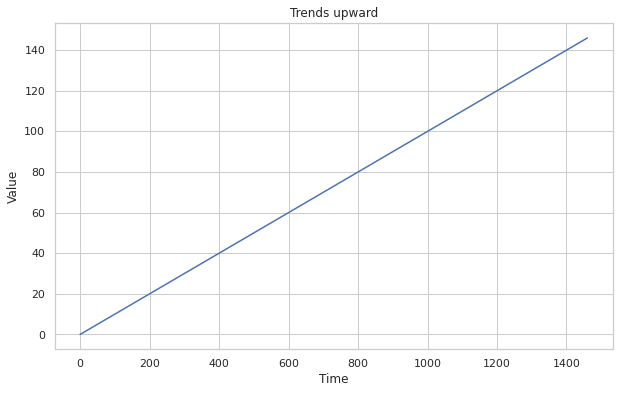

In [3]:
sns.set_style("whitegrid")
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

time = np.arange(4 * 365 + 1)
baseline = 10
series = trend(time, 0.1)

plt.title("Trends upward")
plot_series(time, series)
plt.show()

In [ ]:
def seasonal_pattern(season_time):
    """Patron arbitrario"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """estacionalidad"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

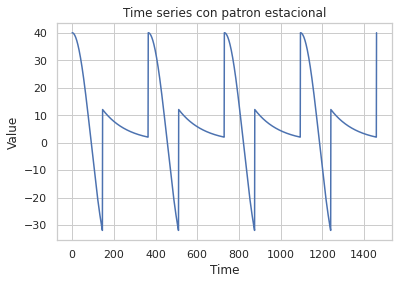

In [ ]:
baseline = 10
amplitude = 40
series = seasonality(time, period=365, amplitude=amplitude)

plt.title("Time series con patron estacional")
plot_series(time, series)
plt.show()

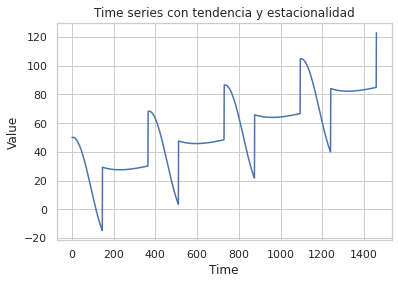

In [ ]:
slope = 0.05
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

plt.title("Time series con tendencia y estacionalidad")
plot_series(time, series)
plt.show()

## Noise

Las series de tiempo de la vida real tienen ruido y la relación señal/ruido a veces puede ser muy baja. Si una serie de tiempo es ruido blanco, es una secuencia de números aleatorios y no se puede predecir. Si la serie de errores de pronóstico no es ruido blanco, sugiere que se podrían realizar mejoras en el modelo predictivo.

Una serie de tiempo es ruido blanco si las variables son independientes y están distribuidas de manera idéntica con una media de cero.

Esto significa que todas las variables tienen la misma varianza ($\sigma_2 $) y cada valor tiene una correlación cero con todos los demás valores de la serie.

In [ ]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

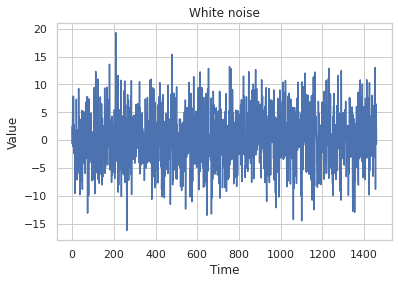

In [ ]:
noise_level = 5
noise=white_noise(time, noise_level, seed=42)

plt.title("White noise")
plot_series(time, noise)
plt.show()

In [ ]:
# summary stats
print(pd.DataFrame(noise).describe())

                 0
count  1461.000000
mean      0.225117
std       4.938768
min     -16.206337
25%      -3.127814
50%       0.244300
75%       3.374097
max      19.263657


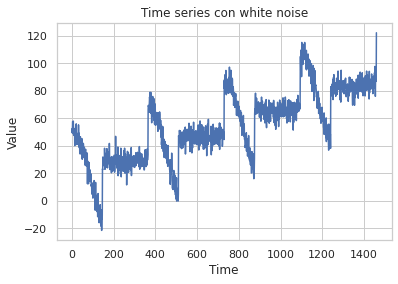

In [ ]:
series += noise

plt.title("Time series con white noise")
plot_series(time, series)
plt.show()

In [ ]:
# summary stats
print(pd.DataFrame(series).describe())

                 0
count  1461.000000
mean     53.954441
std      25.399523
min     -21.603769
25%      33.992976
50%      53.336245
75%      73.622013
max     122.307720


# Trabajando con datos reales

Como ejemplo, veamos datos reales de juegos móviles. Específicamente, analizaremos los anuncios que se ven por hora y el gasto en moneda del juego por día:

In [4]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
# Establecer ruta de acceso en drive
import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


In [5]:
%cd '/content/gdrive/MyDrive/Mujeres digitales sena/Semana 11'

/content/gdrive/MyDrive/Mujeres digitales sena/Semana 11


In [6]:
ads = pd.read_csv('ads.csv', index_col=['Time'], 
                  parse_dates=['Time'])
currency = pd.read_csv('currency.csv', index_col=['Time'], 
                       parse_dates=['Time'])

In [7]:
ads

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
...,...
2017-09-21 19:00:00,155890
2017-09-21 20:00:00,123395
2017-09-21 21:00:00,103080


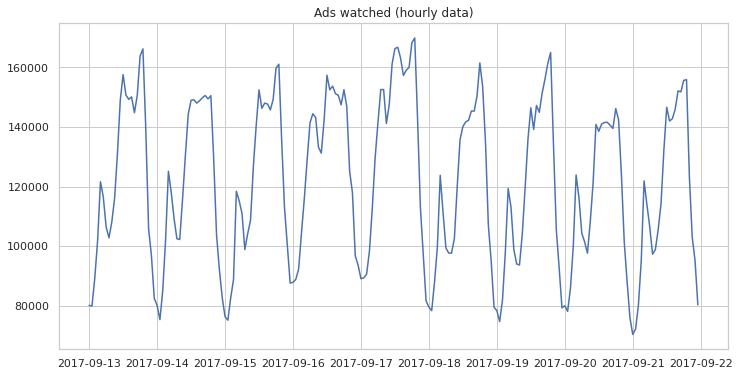

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

In [9]:
currency

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775
...,...
2018-02-20,2166449
2018-02-21,1552313
2018-02-22,2175548


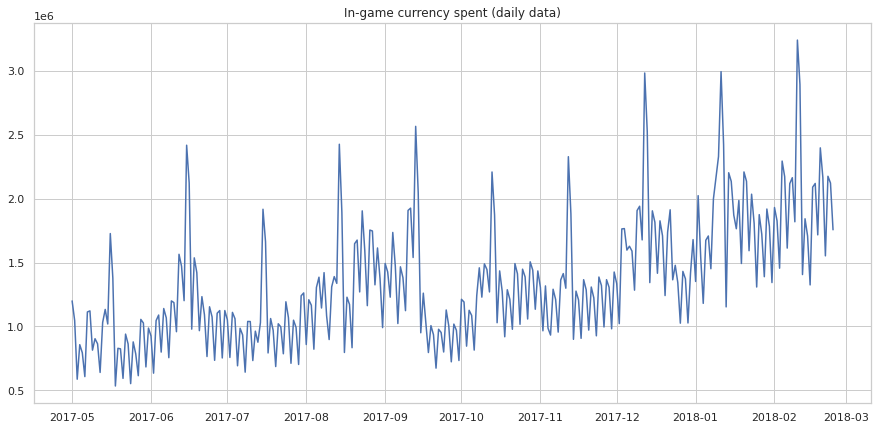

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Move, smoothe, evaluate

Empecemos por una hipótesis ingenua: "mañana será igual que hoy". Sin embargo, en lugar de un modelo como $ \hat{y}_{t} = y_{t-1}$ (que en realidad es una excelente línea de base para cualquier problema de predicción de series de tiempo y, a veces, es imposible de superar), asumiremos que el valor futuro de nuestra variable depende del promedio de sus $k$ valores anteriores. Por lo tanto, usaremos el **moving average**

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [10]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) #predicción para el último día observado (últimas 24 horas)

116805.0

Desafortunadamente, no podemos hacer predicciones lejanas en el futuro; para obtener el valor para el siguiente paso, necesitamos que los valores anteriores se observen realmente. Pero la media móvil tiene otro caso de uso: suavizar la serie temporal original para identificar tendencias. Pandas tiene una implementación disponible con [`DataFrame.rolling (window) .mean ()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Cuanto más ancha sea la ventana, más suave será la tendencia. En el caso de datos muy ruidosos, que se encuentran a menudo en finanzas, este procedimiento puede ayudar a detectar patrones comunes.

In [11]:
def mean_absolute_error(prediction,true_values):
    return np.mean(                                                      # Mean
                np.abs(                                                   # Absolute
                        prediction-true_values                            # Error
                    )
                )

In [12]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Graficar los intervaloes de confianza para valores smoothedes
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Con los intervaloes encontrar valores anormales 
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

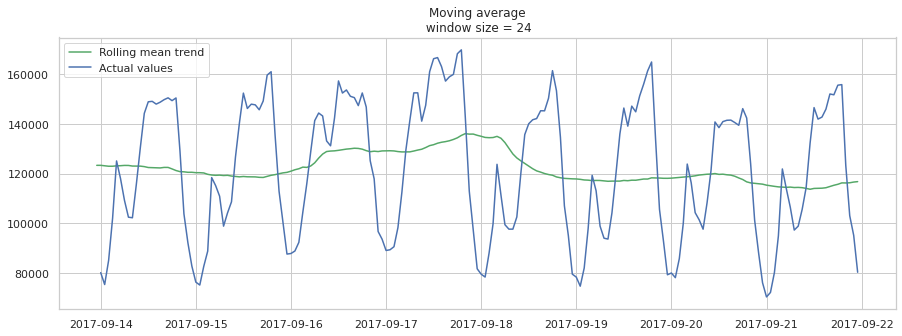

In [13]:
 plotMovingAverage(ads, 24)

Cuando aplicamos el suavizado diario a los datos por horas, pudimos ver claramente la dinámica de los anuncios vistos. Durante los fines de semana, los valores son más altos (más tiempo para jugar los fines de semana) mientras que se ven menos anuncios los días de semana.

In [14]:
def mean_absolute_error(prediction,true_values):
    return np.mean(                                                      # Mean
                np.abs(                                                   # Absolute
                        prediction-true_values                            # Error
                    )
                )

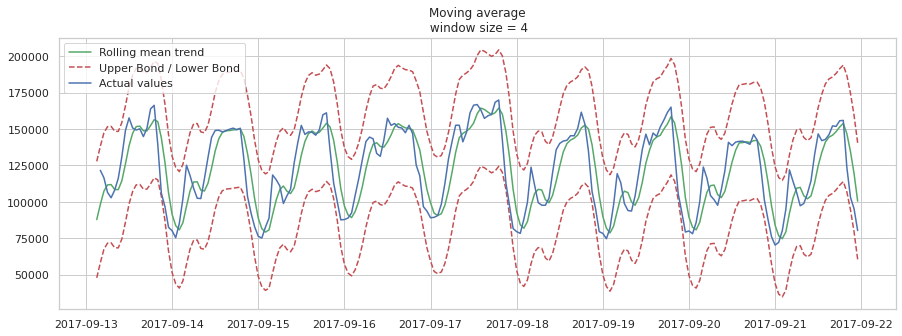

In [ ]:
plotMovingAverage(ads, 4, plot_intervals=True)

Ahora, creemos un sistema de detección de anomalías simple con la ayuda de la media móvil. Desafortunadamente, en este conjunto de datos en particular, todo es más o menos normal, por lo que intencionalmente haremos que uno de los valores sea anormal en nuestro marco de datos ads_anomaly.

In [ ]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # digamso que eliminamos 80% de los ads

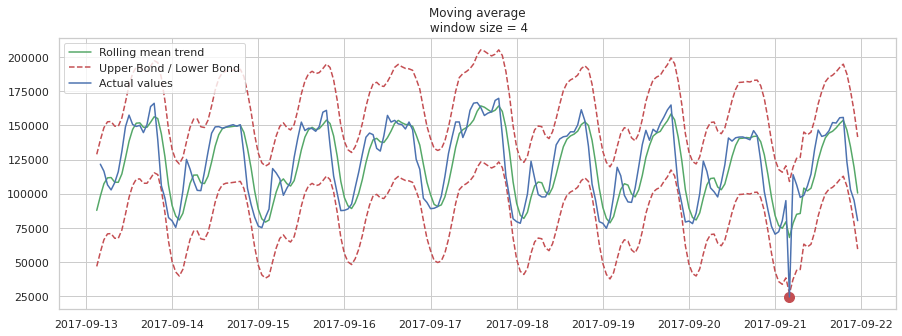

In [ ]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

What about the second series?

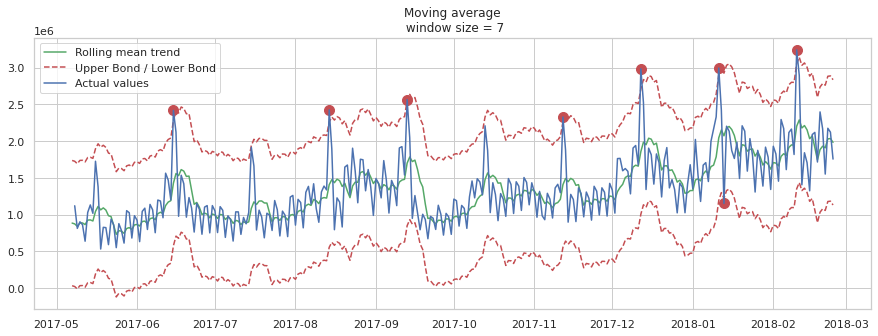

In [ ]:
plotMovingAverage(currency, 7, plot_intervals=True, 
                  plot_anomalies=True) # suavizamiento semanal 

**Series de tiempo estacionarias y no estacionarias**

La estacionariedad es una es una propiedad de una serie de tiempo. Una serie estacionaria es aquella en la que los valores de la serie no son una función del tiempo.

Es decir, las propiedades estadísticas de la serie como media, varianza y autocorrelación son constantes en el tiempo. La autocorrelación de la serie no es más que la correlación de la serie con sus valores anteriores, más adelante.

Una identificación de serie de tiempo estacionaria desprovista de efectos estacionales también.

Antes de comenzar a modelar, debemos mencionar una propiedad tan importante de las series de tiempo: [**estacionariedad**](https://en.wikipedia.org/wiki/Stationary_process).

Si un proceso es estacionario, eso significa que no cambia sus propiedades estadísticas con el tiempo, es decir, su media y varianza. (La constancia de la varianza se llama [homocedasticidad](https://en.wikipedia.org/wiki/Homoscedasticity)) La función de covarianza no depende del tiempo; solo debería depender de la distancia entre observaciones. Puede ver esto visualmente en las imágenes en la publicación de [Sean Abu](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/):


- El gráfico rojo a continuación no es estacionario porque la media aumenta con el tiempo.

<img src="https://habrastorage.org/files/20c/9d8/a63/20c9d8a633ec436f91dccd4aedcc6940.png"/>

- Tuvimos mala suerte con la varianza y vemos la variación variable de los valores a lo largo del tiempo.

<img src="https://habrastorage.org/files/b88/eec/a67/b88eeca676d642449cab135273fd5a95.png"/>

- Finalmente, la covarianza del i-ésimo término y el (i + m)-ésimo término no debería ser una función del tiempo. En el siguiente gráfico, notará que el diferencial se acerca a medida que aumenta el tiempo. Por tanto, la covarianza no es constante con el tiempo en el gráfico de la derecha.

<img src="https://habrastorage.org/files/2f6/1ee/cb2/2f61eecb20714352840748b826e38680.png"/>


Entonces, ¿por qué es tan importante la estacionariedad? Porque es fácil hacer predicciones sobre una serie estacionaria, ya que podemos asumir que las propiedades estadísticas futuras no serán diferentes de las que se observan actualmente. La mayoría de los modelos de series de tiempo, de una forma u otra, intentan predecir esas propiedades (media o varianza, por ejemplo). Las predicciones futuras serían incorrectas si la serie original no fuera estacionaria. Desafortunadamente, la mayoría de las series de tiempo que vemos fuera de los libros de texto no son estacionarias, pero podemos (y debemos) cambiar esto.

Entonces, para combatir la no estacionariedad, tenemos que conocer a nuestro enemigo, por así decirlo. Veamos cómo podemos detectarlo. Observaremos el ruido blanco y las random walks para aprender cómo pasar de uno a otro de forma facil.

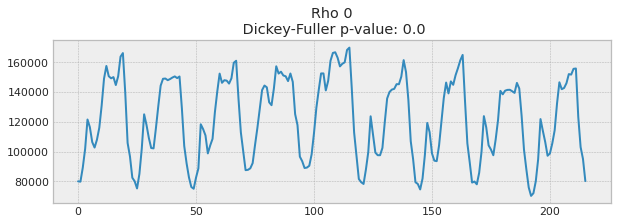

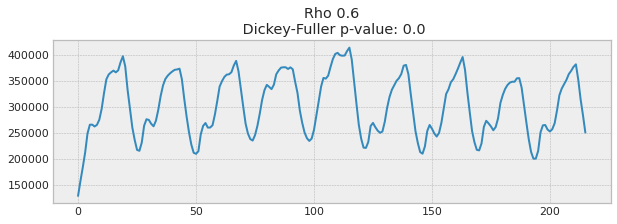

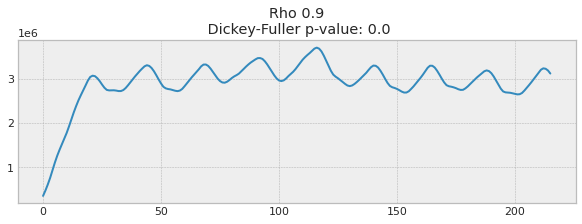

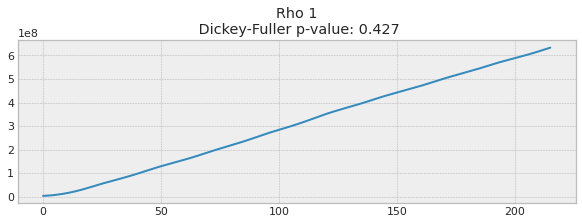

In [15]:
def plotProcess(x,rho=0):
    w = x 
    for t in range(len(x)):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3))) 
x = ads.copy()

for rho in [0, 0.6, 0.9, 1]:
    plotProcess(x.Ads.values,rho=rho)

**Augmented Dickey-Fuller test**

Hipótesis nula (H0): si no se rechaza, sugiere que la serie de tiempo tiene una raíz unitaria, lo que significa que no es estacionaria. **Tiene alguna estructura dependiente del tiempo**.

Hipótesis alternativa (H1): Se rechaza la hipótesis nula; sugiere que la serie de tiempo no tiene una raíz unitaria, lo que significa que es estacionaria. **No tiene una estructura dependiente del tiempo**.

In [16]:
X = x.Ads.values
result = sm.tsa.stattools.adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
#	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.707040
p-value: 0.427489


In [17]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

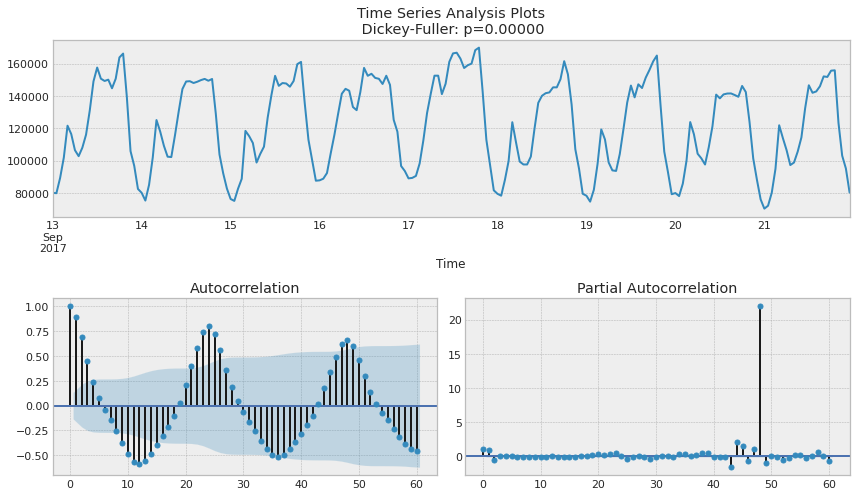

In [18]:
tsplot(ads.Ads, lags=60)

este valor atípico en la gráfica de autocorrelación parcial parece un error de statsmodels, la autocorrelación parcial será <= 1 como cualquier correlación.

Sorprendentemente, las series iniciales son estacionarias; la prueba de Dickey-Fuller rechazó la hipótesis nula de que existe una raíz unitaria. En realidad, podemos ver esto en el gráfico mismo: no tenemos una tendencia visible, por lo que la media es constante y la varianza es bastante estable. Lo único que queda es la estacionalidad, con la que tenemos que lidiar antes de modelar. Para hacerlo, tomemos la "diferencia estacional", que significa una simple resta de la serie de sí misma con un retraso que es igual al período estacional.

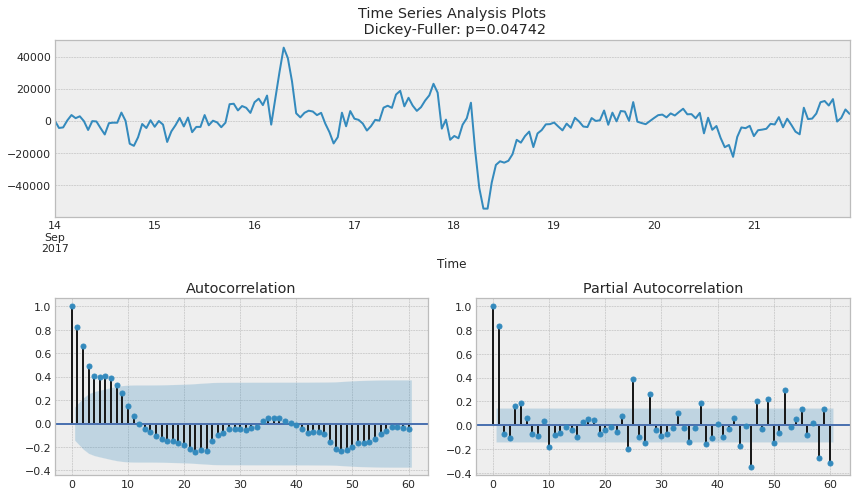

In [19]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

Ahora es mucho mejor con la estacionalidad visible desaparecida. Sin embargo, la función de autocorrelación todavía tiene demasiados retrasos significativos. Para eliminarlos, tomaremos las primeras diferencias, restando la serie de sí misma con retraso 1.

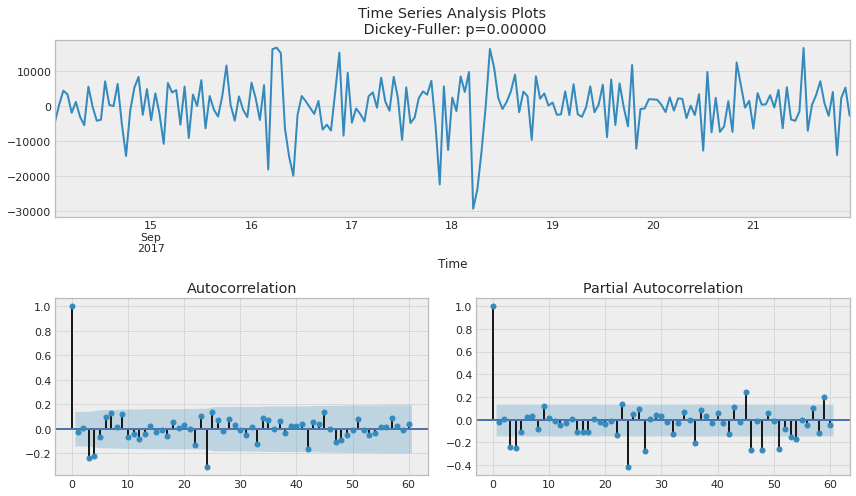

In [20]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

¡Perfecto! Nuestra serie ahora parece algo indescriptible, oscilando alrededor de cero. La prueba de Dickey-Fuller indica que está estacionaria y que ha disminuido el número de picos significativos en ACF. ¡Por fin podemos empezar a modelar!

## ARIMA-family Crash-Course

Explicaremos este modelo construyéndolo letra por letra. $SARIMA(p, d, q) (P, D, Q, s) $, modelo de media móvil de autorregresión estacional:

- $ AR (p) $ - modelo de autorregresión, es decir, regresión de la serie de tiempo sobre sí misma. El supuesto básico es que los valores de la serie actual dependen de sus valores anteriores con algún rezago (o varios rezagos). El retraso máximo en el modelo se denomina $ p $. Para determinar el $ p $ inicial, debe observar el gráfico PACF y encontrar el mayor retraso significativo después del cual **la mayoría** de los demás retrasos se vuelven insignificantes.
- $ MA (q) $ - modelo de promedio móvil. Sin entrar en demasiados detalles, modela el error de la serie de tiempo, nuevamente con el supuesto de que el error actual depende del anterior con cierto rezago, lo que se denomina $ q $. El valor inicial se puede encontrar en el gráfico ACF con la misma lógica que antes.

Combinemos nuestras primeras 4 letras:

$ AR (p) + MA (q) = ARMA (p, q) $

¡Lo que tenemos aquí es el modelo de media móvil autorregresiva! Si la serie es estacionaria, se puede aproximar con estas 4 letras. Continuemos.

- $ I(d)$ - orden de integración. Este es simplemente el número de diferencias no estacionales necesarias para que la serie sea estacionaria. En nuestro caso, es solo 1 porque usamos primeras diferencias.

Al agregar esta letra a las cuatro, obtenemos el modelo $ ARIMA $ que puede manejar datos no estacionarios con la ayuda de diferencias no estacionales. Genial, ¡una carta más para llevar!

- $S(s)$ - esto es responsable de la estacionalidad e iguala la duración del período de temporada de la serie

Con esto, tenemos tres parámetros: $ (P, D, Q) $

- $ P $ - orden de autorregresión para el componente estacional del modelo, que puede derivarse de PACF. Pero debe observar la cantidad de retrasos significativos, que son los múltiplos de la duración del período de la temporada. Por ejemplo, si el período es igual a 24 y vemos que los retrasos 24 y 48 son significativos en el PACF, eso significa que el $ P $ inicial debe ser 2.

- $ Q $ - lógica similar usando el gráfico ACF en su lugar.

- $ D $ - orden de integración estacional. Esto puede ser igual a 1 o 0, dependiendo de si se aplicaron o no diferencias estacionales.


Ahora que sabemos cómo establecer los parámetros iniciales, echemos un vistazo al gráfico final una vez más y establezcamos los parámetros:

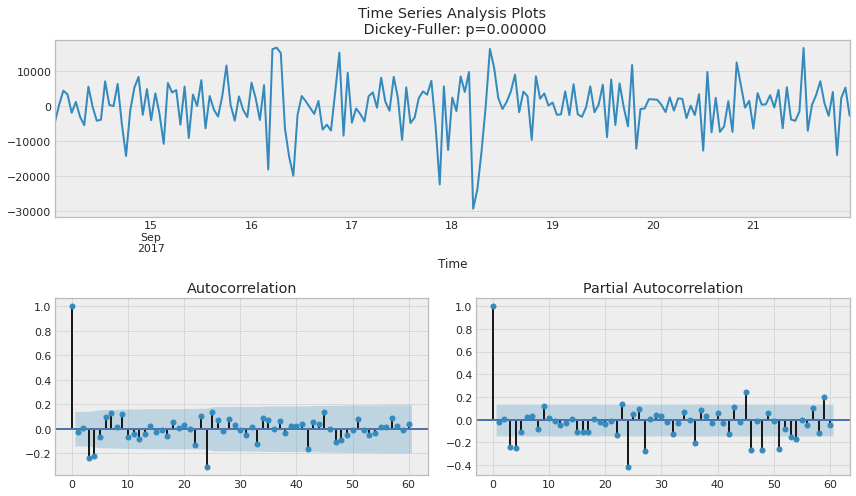

In [21]:
tsplot(ads_diff[24+1:], lags=60)

- $ p $ es probablemente 4 ya que es el último rezago significativo en el PACF, después del cual, la mayoría de los demás no son significativos.
- $ d $ es igual a 1 porque tuvimos las primeras diferencias
- $ q $ debería estar en algún lugar alrededor de 4, así como se ve en el ACF
- $ P $ podría ser 2, ya que los retrasos 24 y 48 son algo significativos en el PACF
- $ D $ nuevamente es igual a 1 porque realizamos una diferenciación estacional
- $ Q $ es probablemente 1. El desfase 24º en ACF es significativo, mientras que el 48º no lo es.

In [22]:
# Definir valores iniciales 
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creando lista de posibles combinaciones 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
len(parameters_list)

[(2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1), (2, 3, 0, 0), (2, 3, 0, 1), (2, 3, 1, 0), (2, 3, 1, 1), (2, 4, 0, 0), (2, 4, 0, 1), (2, 4, 1, 0), (2, 4, 1, 1), (3, 2, 0, 0), (3, 2, 0, 1), (3, 2, 1, 0), (3, 2, 1, 1), (3, 3, 0, 0), (3, 3, 0, 1), (3, 3, 1, 0), (3, 3, 1, 1), (3, 4, 0, 0), (3, 4, 0, 1), (3, 4, 1, 0), (3, 4, 1, 1), (4, 2, 0, 0), (4, 2, 0, 1), (4, 2, 1, 0), (4, 2, 1, 1), (4, 3, 0, 0), (4, 3, 0, 1), (4, 3, 1, 0), (4, 3, 1, 1), (4, 4, 0, 0), (4, 4, 0, 1), (4, 4, 1, 0), (4, 4, 1, 1)]


36

In [23]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # Tenemos que hacer un try-except porque algunas combinaciones fallan en converger
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # guardar el mejor modelo, AIC y parametros
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Ordener de manera creciente, a menor valor de AIC es MEJOR
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 7min 6s, sys: 5min 6s, total: 12min 13s
Wall time: 6min 15s


In [ ]:
result_table.head()

,parameters,aic
0,"(2, 3, 1, 1)",3888.642174
1,"(3, 2, 1, 1)",3888.763568
2,"(4, 2, 1, 1)",3890.279740
3,"(3, 3, 1, 1)",3890.513196
4,"(2, 4, 1, 1)",3892.302849


In [ ]:
# Ajustar los parametros para dejar el valor mas bajo de AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, 1, 24)   Log Likelihood               -1936.321
Date:                            Mon, 11 Oct 2021   AIC                           3888.642
Time:                                    20:44:29   BIC                           3914.660
Sample:                                09-13-2017   HQIC                          3899.181
                                     - 09-21-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.5503      0.306   

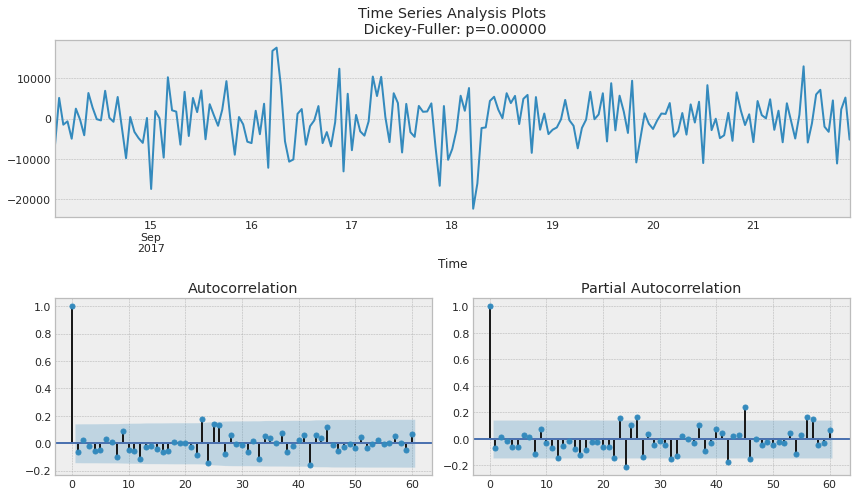

In [ ]:
tsplot(best_model.resid[24+1:], lags=60)

Está claro que los residuos son estacionarios y no hay autocorrelaciones aparentes. Hagamos predicciones usando nuestro modelo.

In [ ]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [ ]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # Adicionar los valores del modelo
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # hacer un cambio en los pasos s + d, porque estos valores no fueron observados por el modelo
     # debido a la diferenciación
    data['arima_model'][:s+d] = np.NaN
    
    # pronosticando n_pasos adelante    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calcular el error, nuevamente habiendo cambiado en los pasos s + d desde el principio
    error = MAPE(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

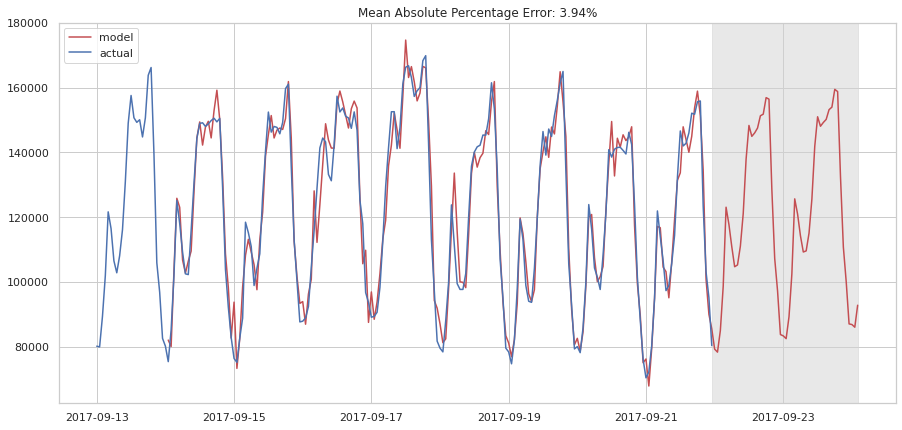

In [ ]:
plotSARIMA(ads, best_model, 50)

In [ ]:
ads.shape

(216, 1)

In [ ]:
48/216

0.2222222222222222

In [ ]:
best_model.fittedvalues

Time
2017-09-13 00:00:00         0.000000
2017-09-13 01:00:00     86657.830200
2017-09-13 02:00:00     81893.869417
2017-09-13 03:00:00     74980.175198
2017-09-13 04:00:00     92064.376658
                           ...      
2017-09-21 19:00:00    151394.104418
2017-09-21 20:00:00    134501.828378
2017-09-21 21:00:00    100789.282753
2017-09-21 22:00:00     89956.557827
2017-09-21 23:00:00     85489.050354
Length: 216, dtype: float64

In [ ]:
ads

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
...,...
2017-09-21 19:00:00,155890
2017-09-21 20:00:00,123395
2017-09-21 21:00:00,103080


In [ ]:
# Predicciones de las proximas 24 horas
forecast = best_model.predict(start = ads.shape[0], end = ads.shape[0]+24)
forecast
#forecast = data.arima_model.append(forecast)

2017-09-22 00:00:00     79210.851621
2017-09-22 01:00:00     78272.433426
2017-09-22 02:00:00     84933.781050
2017-09-22 03:00:00     98608.012609
2017-09-22 04:00:00    123063.539343
2017-09-22 05:00:00    117732.991991
2017-09-22 06:00:00    110844.417511
2017-09-22 07:00:00    104664.099233
2017-09-22 08:00:00    105220.111697
2017-09-22 09:00:00    111023.812551
2017-09-22 10:00:00    121143.487036
2017-09-22 11:00:00    137881.583900
2017-09-22 12:00:00    148332.813208
2017-09-22 13:00:00    144963.827168
2017-09-22 14:00:00    146023.319852
2017-09-22 15:00:00    147533.829431
2017-09-22 16:00:00    151318.545817
2017-09-22 17:00:00    151827.285028
2017-09-22 18:00:00    156926.081367
2017-09-22 19:00:00    156463.955669
2017-09-22 20:00:00    128645.790683
2017-09-22 21:00:00    107240.427901
2017-09-22 22:00:00     97193.244971
2017-09-22 23:00:00     83711.443158
2017-09-23 00:00:00     83296.933315
Freq: H, dtype: float64

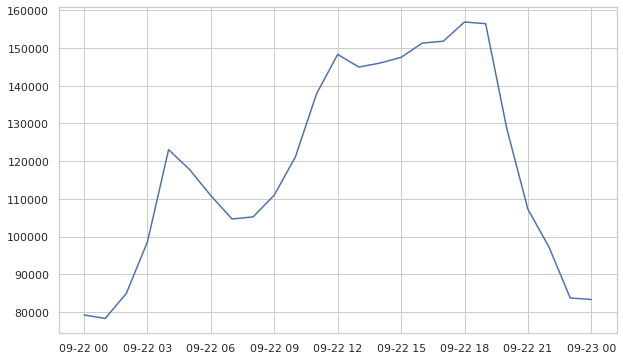

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(forecast)

Al final, obtuvimos predicciones muy adecuadas. Nuestro modelo se equivocó en un 4,01% de media, lo que es muy, muy bueno. Sin embargo, los costos generales de preparar los datos, hacer que la serie sea estacionaria y seleccionar los parámetros puede que no valgan esta precisión.

# Taller 10

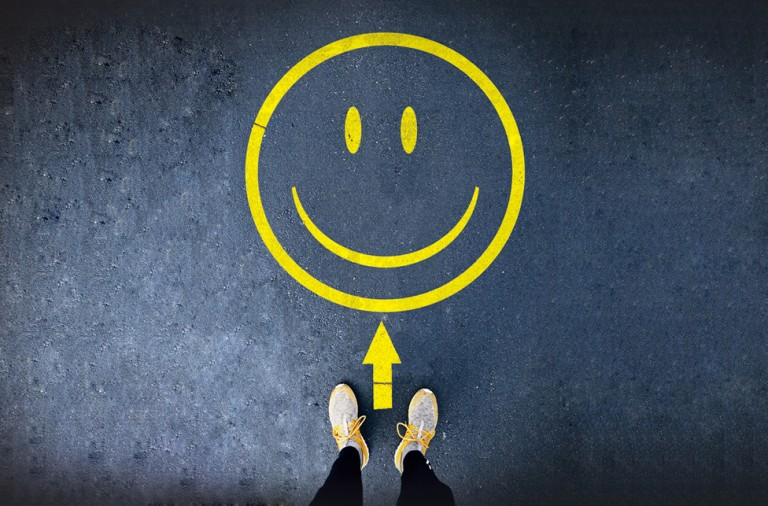

In [24]:
currency

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775
...,...
2018-02-20,2166449
2018-02-21,1552313
2018-02-22,2175548


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8aa8e2950>]],
      dtype=object)

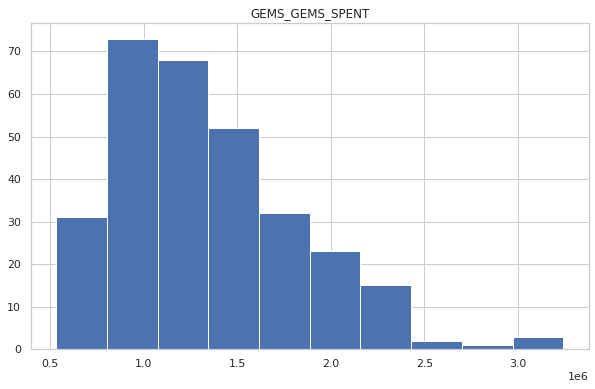

In [25]:
currency.hist()

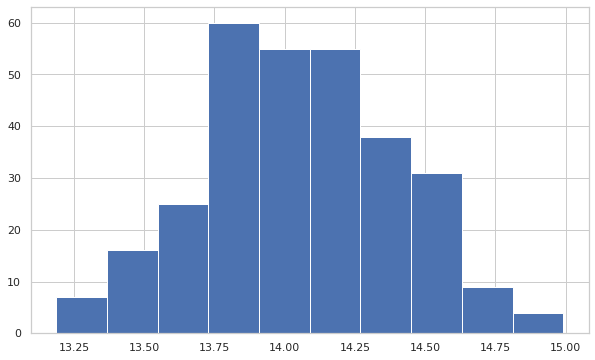

In [26]:
from matplotlib import pyplot
from numpy import log
X=currency.values
X= log(X)
pyplot.hist(X)
pyplot.show()

In [ ]:
# Se ejecuta una transformación logaritmica "Log(X)", y se nota una distribución mas gaussiana o normal, donde se puede ver probabilidades de un valor y los menores o mayores que el.
# https://www.sac.org.ar/cuestion-de-metodo/que-es-la-distribucion-normal-o-gaussiana/.

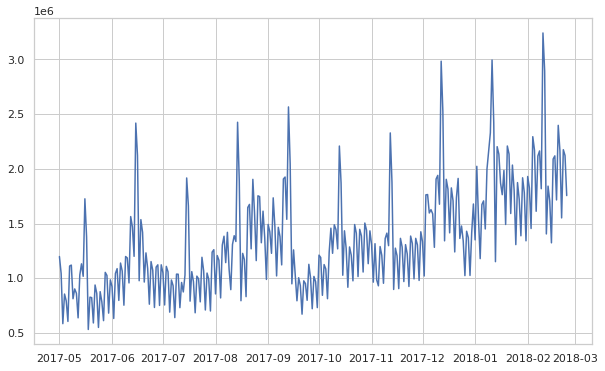

In [27]:
plt.figure(figsize=(10,6))
plt.plot(currency)

1. Verificar que la serie currency no es producto del azar usando la prueba Dickey Fuller

In [28]:
from statsmodels.tsa.stattools import adfuller
X= currency.GEMS_GEMS_SPENT
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#print('Critical Values:')
#for key, value in result[4].items():
  #print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.816011
p-value: 0.372542


2. Realizar los graficos de ACF y PACF para la serie orginal currency e interprete el p valor a la luz de la prueba Dickey Fuller (Pueden usar de ayuda la funcion tsplot)

In [29]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

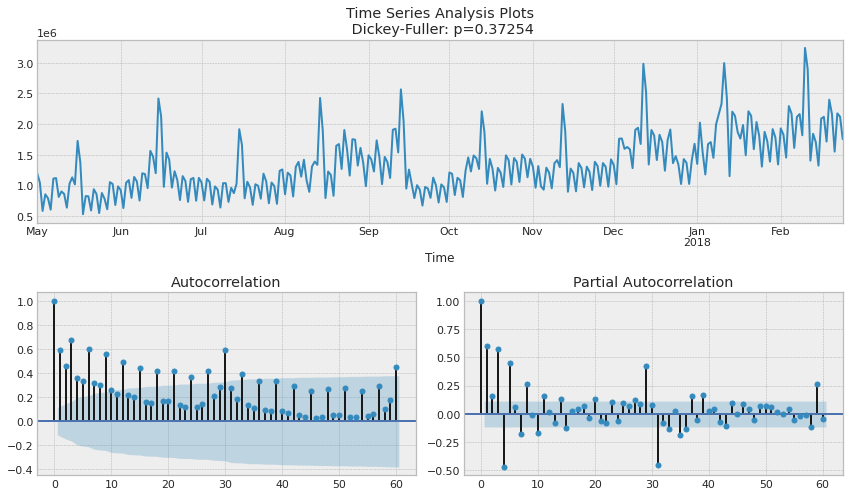

In [30]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

...... p-value es mayor a 0.05: No se rechaza la hipótesis nula (H0), el data NO es estacionario y tiene alguna estructura dependiente del tiempo.

3. Utilice una diferenciacion apropiada para convertir la serie a estacionaria. Justifique su respuesta.

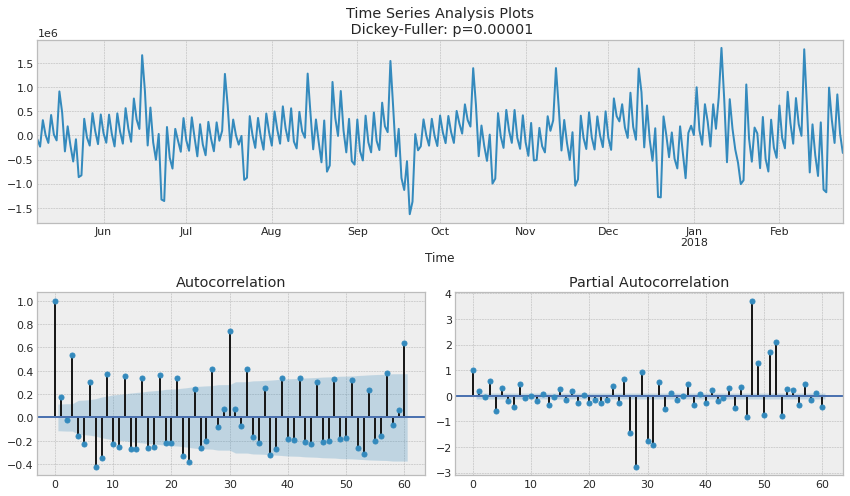

In [33]:
gems_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(7)
tsplot(gems_diff[7:], lags=60)

la función de autocorrelación todavía tiene demasiados retrasos significativos. Para eliminarlos, tomaremos las primeras diferencias, restando la serie de sí misma con retraso 1.

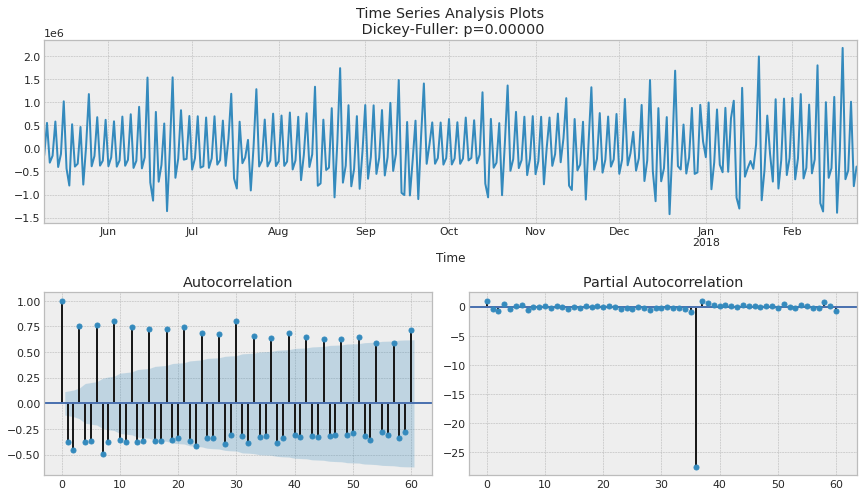

In [34]:
gems_diff = gems_diff - gems_diff.shift(1)
tsplot(gems_diff[7+1:], lags=60)

Ahora oscila alrededor de cero. La prueba de Dickey-Fuller indica que está estacionaria y que ha disminuido el número de picos significativos en ACF.

4. Identificar los parametros (p,d,q)(P,D,Q) probables para su modelo SARIMAX y justifique su eleccion.

R/// 
**p** es 2, el primer rezago se da en 2 segun el AFC
**d** es igual a 1
**q** alrededor de 2
**P** entre 0 y 1
**D** es igual a 1 porque se hizo una diferenciación estacional.
**Q** es igual a 1
**s** es igual a 7 porque es diario.

5. Definir una lista de parametros inicales para p,q,P,Q asi como valores fijos para d, D y s y guardelos en ``parameters_list`` 

In [35]:
# Definir valores iniciales 
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 7

# creando lista de posibles combinaciones 
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(parameters_list)
len(parameters_list)

[(2, 2, 0, 0), (2, 2, 0, 1), (2, 2, 1, 0), (2, 2, 1, 1), (2, 3, 0, 0), (2, 3, 0, 1), (2, 3, 1, 0), (2, 3, 1, 1), (2, 4, 0, 0), (2, 4, 0, 1), (2, 4, 1, 0), (2, 4, 1, 1), (3, 2, 0, 0), (3, 2, 0, 1), (3, 2, 1, 0), (3, 2, 1, 1), (3, 3, 0, 0), (3, 3, 0, 1), (3, 3, 1, 0), (3, 3, 1, 1), (3, 4, 0, 0), (3, 4, 0, 1), (3, 4, 1, 0), (3, 4, 1, 1), (4, 2, 0, 0), (4, 2, 0, 1), (4, 2, 1, 0), (4, 2, 1, 1), (4, 3, 0, 0), (4, 3, 0, 1), (4, 3, 1, 0), (4, 3, 1, 1), (4, 4, 0, 0), (4, 4, 0, 1), (4, 4, 1, 0), (4, 4, 1, 1)]


36

6. Utilizar la funcion ``optimizeSARIMA(parameters_list, d, D, s)`` para obtener una lista de modelos con su respectivo AIC y determinar la mejor combinacion de parametros (p,q,P,Q)

In [36]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # Tenemos que hacer un try-except porque algunas combinaciones fallan en converger
        try:
            model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # guardar el mejor modelo, AIC y parametros
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Ordener de manera creciente, a menor valor de AIC es MEJOR
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [37]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/36 [00:00<?, ?it/s]

CPU times: user 2min 13s, sys: 1min 39s, total: 3min 52s
Wall time: 1min 59s


In [38]:
result_table.head()

,parameters,aic
0,"(4, 3, 0, 1)",8085.671069
1,"(3, 3, 0, 1)",8085.731038
2,"(4, 3, 1, 1)",8089.086028
3,"(3, 3, 1, 1)",8089.676974
4,"(2, 3, 0, 1)",8101.423136


In [48]:
# Ajustar los parametros para dejar el valor mas bajo de AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                   GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(4, 1, 3)x(0, 1, 1, 7)   Log Likelihood               -4033.836
Date:                           Wed, 13 Oct 2021   AIC                           8085.671
Time:                                   17:05:35   BIC                           8118.762
Sample:                               05-01-2017   HQIC                          8098.926
                                    - 02-24-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0441      0.098     -0.450      0.653      -0.236       0.148
ar.L2         -0.2507      0.059     -4.235

7. Con base en la eleccion de paramatros ajuste un modelo y nombrelo ``mejor_modelo`` por medio de la funcion ``sm.tsa.statespace.SARIMAX``

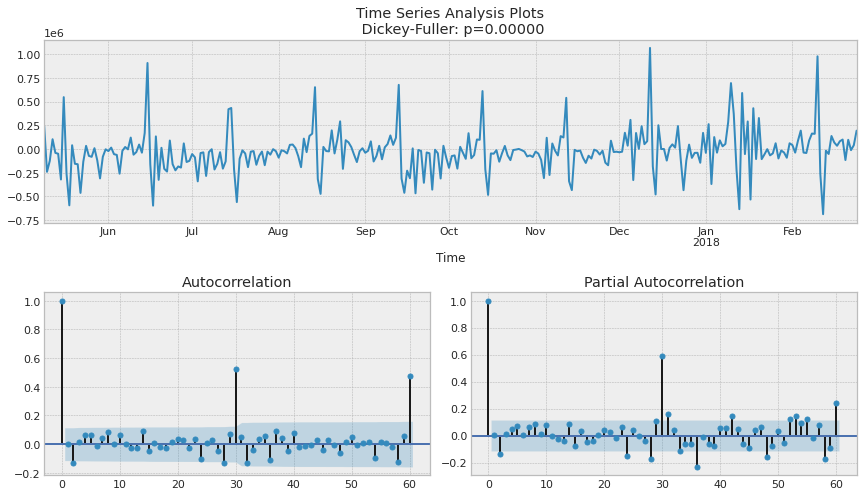

In [49]:
tsplot(best_model.resid[7+1:], lags=60)

8. Obtenga predicciones para las proximas dos semanas utilizando el modelo ``mejor_modelo`` y la funcion previamente creada ``plotSARIMA``. Evalue el modelo respecto a los datos reales usando la metrica MAPE(Mean Absolute Percentage Error). Justifique si su modelo es apropiado para las predicciones o si no es conveniente.

In [50]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [51]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # Adicionar los valores del modelo
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # hacer un cambio en los pasos s + d, porque estos valores no fueron observados por el modelo
     # debido a la diferenciación
    data['arima_model'][:s+d] = np.NaN
    
    # pronosticando n_pasos adelante    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calcular el error, nuevamente habiendo cambiado en los pasos s + d desde el principio
    error = MAPE(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

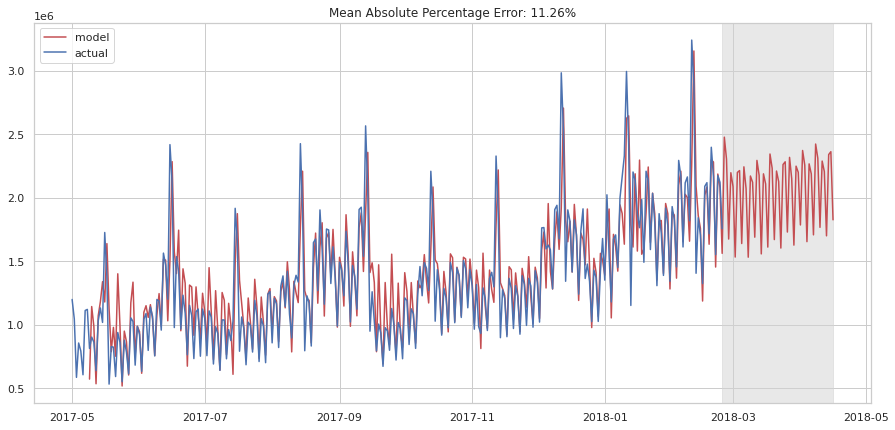

In [53]:
plotSARIMA(currency, best_model, 50)

In [54]:
best_model.fittedvalues

Time
2017-05-01             NaN
2017-05-02             NaN
2017-05-03             NaN
2017-05-04             NaN
2017-05-05             NaN
                  ...     
2018-02-20    2.282176e+06
2018-02-21    1.454853e+06
2018-02-22    2.187094e+06
2018-02-23    2.082170e+06
2018-02-24    1.562592e+06
Length: 300, dtype: float64

In [55]:
# Predicciones de los proximos 7 días
forecast = best_model.predict(start = currency.shape[0], end = currency.shape[0]+7)
forecast
#forecast = data.arima_model.append(forecast)

2018-02-25    2.477678e+06
2018-02-26    2.305111e+06
2018-02-27    1.675280e+06
2018-02-28    2.197541e+06
2018-03-01    2.089298e+06
2018-03-02    1.533476e+06
2018-03-03    2.199729e+06
2018-03-04    2.214421e+06
Freq: D, dtype: float64

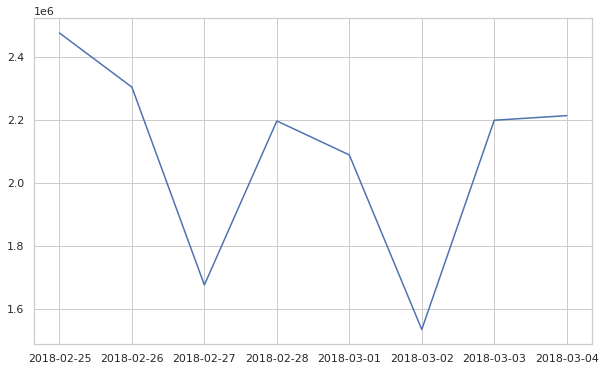

In [56]:
plt.figure(figsize=(10,6))
plt.plot(forecast)



*   El modelo se equivocó un 11% de la media.


